<a href="https://colab.research.google.com/github/mathmca/udemy_portfolio/blob/main/udemy_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Baixando os dados

In [206]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [207]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [208]:
! cp kaggle.json ~/.kaggle/

In [209]:
! chmod 600 ~/.kaggle/kaggle.json

In [210]:
! kaggle datasets download -d andrewmvd/udemy-courses

udemy-courses.zip: Skipping, found more recently modified local copy (use --force to force download)


In [211]:
from zipfile import ZipFile
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score


class data_saveload():
  def __init__(self, data_path: str, ArchName: str, filename: str):
    self.data_path = data_path
    self.filename = filename
    self.ArchName = ArchName
  def savedata(self):
    os.makedirs(self.data_path, exist_ok=True)
    if self.ArchName.endswith('.zip'):
      zip_path = os.path.join(os.getcwd(), self.ArchName)
      with ZipFile(zip_path, 'r') as zip:
        zip.printdir()
        zip.extractall(path=self.data_path)
        print('Finished!')
    else:
      os.path.join(data_path, self.filename)
  def loadata(self):
    arch = os.path.join(self.data_path, self.filename)
    return pd.read_csv(arch)
  def load_save(self):
    self.savedata()
    return self.loadata()

data_path = os.path.join(os.getcwd(), "database")

In [212]:
df_original = data_saveload(data_path=data_path, ArchName='udemy-courses.zip', filename='udemy_courses.csv')
df = df_original.load_save()

File Name                                             Modified             Size
udemy_courses.csv                              2020-05-17 00:01:44       693946
Finished!


## Data Overview

In [213]:
# Dropping irrelevant columns

df.drop(labels=['course_id', 'course_title', 'url', 'published_timestamp'], inplace=True, axis=1)

In [214]:
df.head()

,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject
0,True,200,2147,23,51,All Levels,1.5,Business Finance
1,True,75,2792,923,274,All Levels,39.0,Business Finance
2,True,45,2174,74,51,Intermediate Level,2.5,Business Finance
3,True,95,2451,11,36,All Levels,3.0,Business Finance
4,True,200,1276,45,26,Intermediate Level,2.0,Business Finance


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_paid           3678 non-null   bool   
 1   price             3678 non-null   int64  
 2   num_subscribers   3678 non-null   int64  
 3   num_reviews       3678 non-null   int64  
 4   num_lectures      3678 non-null   int64  
 5   level             3678 non-null   object 
 6   content_duration  3678 non-null   float64
 7   subject           3678 non-null   object 
dtypes: bool(1), float64(1), int64(4), object(2)
memory usage: 204.9+ KB


In [216]:
df.describe()

,price,num_subscribers,num_reviews,num_lectures,content_duration
count,3678.000000,3678.000000,3678.000000,3678.000000,3678.000000
mean,66.049483,3197.150625,156.259108,40.108755,4.094517
std,61.005755,9504.117010,935.452044,50.383346,6.053840
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,111.000000,4.000000,15.000000,1.000000
50%,45.000000,911.500000,18.000000,25.000000,2.000000
75%,95.000000,2546.000000,67.000000,45.750000,4.500000
max,200.000000,268923.000000,27445.000000,779.000000,78.500000


In [217]:
# Looking for duplicated values
print(df.duplicated().value_counts())

False    3669
True        9
dtype: int64


In [218]:
df.drop_duplicates(inplace=True)

In [219]:
print(df.is_paid.unique(), df.level.unique(), df.subject.unique(), '\n-----------') # For dummy selection
print(df.isnull().sum()) # Looking for missing values (None)

[ True False] ['All Levels' 'Intermediate Level' 'Beginner Level' 'Expert Level'] ['Business Finance' 'Graphic Design' 'Musical Instruments'
 'Web Development'] 
-----------
is_paid             0
price               0
num_subscribers     0
num_reviews         0
num_lectures        0
level               0
content_duration    0
subject             0
dtype: int64


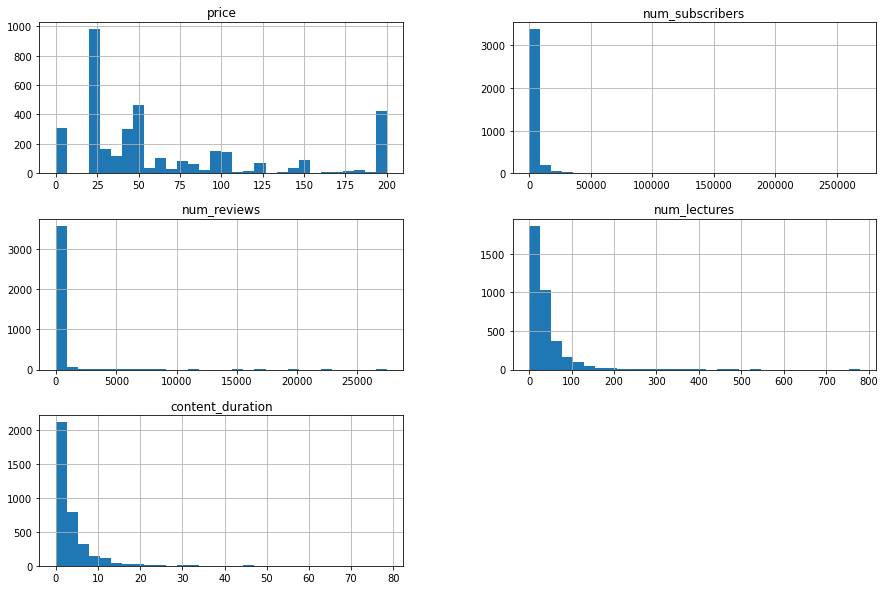

In [220]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

In [221]:
df.corr()

,is_paid,price,num_subscribers,num_reviews,num_lectures,content_duration
is_paid,1.000000,0.329060,-0.266996,-0.087408,0.112972,0.094703
price,0.329060,1.000000,0.050327,0.113522,0.329800,0.293093
num_subscribers,-0.266996,0.050327,1.000000,0.651062,0.158209,0.162027
num_reviews,-0.087408,0.113522,0.651062,1.000000,0.242975,0.228815
num_lectures,0.112972,0.329800,0.158209,0.242975,1.000000,0.801601
content_duration,0.094703,0.293093,0.162027,0.228815,0.801601,1.000000


In [222]:
px.scatter_matrix(df, dimensions=['price', 'num_subscribers', 'num_reviews',
       'num_lectures', 'content_duration'], color='is_paid', title='Scatter Matrix', height=900)

Testing features combinations

In [223]:
df['durationbylect'] = df['content_duration']//df['num_lectures']
df['reviewpersubs'] = df['num_reviews']//df['num_subscribers']
df.corrwith(df['price']) 
#There is not any relevant combination, dropping these columns
df.drop(['durationbylect', 'reviewpersubs'], axis=1, inplace=True)

Removing Outliers

In [224]:
df = df[df['num_lectures'] < 700]
df = df[df['num_subscribers'] < 200000]
df

,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject
0,True,200,2147,23,51,All Levels,1.5,Business Finance
1,True,75,2792,923,274,All Levels,39.0,Business Finance
2,True,45,2174,74,51,Intermediate Level,2.5,Business Finance
3,True,95,2451,11,36,All Levels,3.0,Business Finance
4,True,200,1276,45,26,Intermediate Level,2.0,Business Finance
...,...,...,...,...,...,...,...,...
3673,True,100,1040,14,21,All Levels,2.0,Web Development
3674,True,25,306,3,42,Beginner Level,3.5,Web Development
3675,True,40,513,169,48,All Levels,3.5,Web Development
3676,True,50,300,31,38,All Levels,3.0,Web Development


## Transformation Pipeline

* A lot of our data is too much spread out, mainly the price! None of them looks like a normal. We have long tails distributions, it may be a problem. We are going to do the feature scaling to fix that. 

* After this brief view, let's split our train and test dataset before do any data transformation. I will use the random sample and I will let the seed, because I will restart this notebook several times.

In [225]:
# Splitting the data

x = df.drop('price', axis=1)
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [226]:
# Splitting by categories

x_train_num = x_train.select_dtypes(include=[np.number])
x_train_cat = x_train.select_dtypes(exclude=[np.number, 'bool'])
x_train_binary = x_train.select_dtypes(include='bool')

In [227]:
# Manually checking if everything fits perfectly
encoder = OneHotEncoder()
x_train_cat_tr = encoder.fit_transform(x_train_cat[['level', 'subject']])
print(encoder.get_feature_names_out())

['level_All Levels' 'level_Beginner Level' 'level_Expert Level'
 'level_Intermediate Level' 'subject_Business Finance'
 'subject_Graphic Design' 'subject_Musical Instruments'
 'subject_Web Development']


I need to create a custom class for the "LabelBinarizer" beucase he does not handle more than 2 arguments

In [228]:
class binarytransformer(BaseEstimator, TransformerMixin):
  def __init__(self, sparse_output=False):
    self.sparse_output = sparse_output
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    binarizer = LabelBinarizer(sparse_output=self.sparse_output)
    return binarizer.fit_transform(X)

### Pipeline

I am doing a manual dummy transformation without any scaling

In [229]:
# Creating the dummy for "is_paid"
x_train['is_paid'] = x_train['is_paid'].apply(lambda x: 1 if x == True else 0)

# Creating dummy variables for "level"
dummy_level = pd.get_dummies(x_train.level)
concat_df = pd.concat([x_train, dummy_level], axis=1)

#Creating dummy variables for "subject"
dummy_subject = pd.get_dummies(x_train.subject)
subject_df = pd.concat([concat_df, dummy_subject], axis=1)

#The final DataFrame
datam = subject_df.drop(['level', 'subject'], axis=1)
datam

,is_paid,num_subscribers,num_reviews,num_lectures,content_duration,All Levels,Beginner Level,Expert Level,Intermediate Level,Business Finance,Graphic Design,Musical Instruments,Web Development
1843,1,117,11,32,3.0,1,0,0,0,0,0,1,0
2259,1,1,0,26,1.5,0,1,0,0,0,0,1,0
1773,1,5,0,29,2.0,1,0,0,0,0,1,0,0
2449,1,33,5,26,2.0,1,0,0,0,0,0,1,0
3050,1,260,22,64,11.0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,1,80,10,27,5.5,1,0,0,0,1,0,0,0
1301,1,1504,10,9,1.5,0,1,0,0,0,1,0,0
864,0,5529,90,5,2.0,1,0,0,0,1,0,0,0
3518,1,1062,20,32,3.5,1,0,0,0,0,0,0,1


In [230]:
px.imshow(datam.corr(), text_auto=True, width=1400, height=1000, template='ggplot2')

In [231]:
# Defining the numerical Pipeline

pipeline_num = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
  ])

# Putting all together in the Transformer

final_pipeline = ColumnTransformer([
    ('numerical', pipeline_num, list(x_train_num)),
    ('categorical', OneHotEncoder(sparse=False), list(x_train_cat)),
    ('binarizer', binarytransformer(), ['is_paid'])
  ])

# Fitting and Transforming the specified columns

x_train_tr = final_pipeline.fit_transform(x_train)

In [232]:
dataf = pd.DataFrame(x_train_tr, columns=list(x_train_num.columns) + list(encoder.get_feature_names_out()) + ['is_paid'], index = x_train.index)
dataf.columns = dataf.columns.str.replace('/|(level_)|(subject_)|/', '', regex=True)
dataf

,num_subscribers,num_reviews,num_lectures,content_duration,All Levels,Beginner Level,Expert Level,Intermediate Level,Business Finance,Graphic Design,Musical Instruments,Web Development,is_paid
1843,-0.348935,-0.147563,-0.165506,-0.186633,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2259,-0.362409,-0.158753,-0.283725,-0.431522,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1773,-0.361944,-0.158753,-0.224615,-0.349892,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2449,-0.358692,-0.153666,-0.283725,-0.349892,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3050,-0.332326,-0.136373,0.464997,1.119437,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,-0.353233,-0.148580,-0.264022,0.221514,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1301,-0.187836,-0.148580,-0.618680,-0.431522,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
864,0.279666,-0.067200,-0.697492,-0.349892,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3518,-0.239174,-0.138408,-0.165506,-0.105004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


## Model selection and training

In [233]:
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
def display_errors(labels, predictions):
  print('RMSE:', mean_squared_error(labels, predictions, squared=False))
  print('MEA:', mean_absolute_error(labels, predictions))

def dispaly_accuracy(labels, predictions):
  errors = abs(labels - predictions)
  mape = 100 * np.mean(errors / labels)
  accuracy = 100 - mape
  print(f"Accuracy: {accuracy:5.2f} %")

def display_scores(scores):
  print(f'Mean: {scores.mean()}\nStd: {scores.std()}')


linreg_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('linreg', LinearRegression())
  ])

tree_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('tree', DecisionTreeRegressor())
  ])

forest_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('forest', RandomForestRegressor())
  ])

svr_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('svr', SVR(kernel='rbf', C=100))
  ])

knn_pipeline = Pipeline([
    ('transformation', final_pipeline),
    ('knn', KNeighborsRegressor())
  ])

pipes = [linreg_pipeline, tree_pipeline,
         forest_pipeline, svr_pipeline, knn_pipeline]

names = ['Linear Regression', 'Decision Tree', 
         'Random Forest', 'SVR', 'KNN']


for i, pipe in zip(names, pipes):
  pipe.fit(x_train, y_train)
  predictions = pipe.predict(x_train)
  print('Name:', i)
  display_errors(y_train, predictions)
  dispaly_accuracy(y_train, predictions)

Name: Linear Regression
RMSE: 53.592943196073286
MEA: 41.21190582174448
Accuracy:  -inf %
Name: Decision Tree
RMSE: 1.488677576702931
MEA: 0.0477326968973747
Accuracy: 99.84 %
Name: Random Forest
RMSE: 19.865820165996475
MEA: 14.476686555290375
Accuracy:  -inf %
Name: SVR
RMSE: 53.70237638596723
MEA: 33.4376344405301
Accuracy:  -inf %
Name: KNN
RMSE: 47.32061971402458
MEA: 33.719740879645414
Accuracy:  -inf %


In [234]:
# Cross-Validation
for i, model in zip(names, pipes):
  print('Model:', i)
  scores = cross_val_score(model, x_train, y_train,
                               scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-scores)
  display_scores(rmse_scores)
  print('xxxxxxxxxxxxxx')

Model: Linear Regression
Mean: 53.79396630000249
Std: 2.392340798035001
xxxxxxxxxxxxxx
Model: Decision Tree
Mean: 73.91450548987403
Std: 3.2656263103144956
xxxxxxxxxxxxxx
Model: Random Forest
Mean: 53.10715088830936
Std: 1.9337485299272652
xxxxxxxxxxxxxx
Model: SVR
Mean: 55.8886149019434
Std: 2.4097861287086006
xxxxxxxxxxxxxx
Model: KNN
Mean: 57.234562476630174
Std: 2.22114737325209
xxxxxxxxxxxxxx


## Model Boosting

In [235]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


model = RandomForestRegressor()
rand_search = RandomizedSearchCV(model, n_iter=100, cv=4,
                                 param_distributions=random_grid,
                                 scoring='neg_mean_squared_error',
                                 verbose=2, n_jobs=-1, random_state=42)

rand_search.fit(x_train_tr, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [240]:
f_importance = rand_search.best_estimator_.feature_importances_
attributes = dataf.columns
print(sorted(zip(f_importance, attributes), reverse=True))
print('\nBest Score Error:', np.sqrt(-rand_search.best_score_))

[(0.22133066455505038, 'num_lectures'), (0.19595625123891985, 'is_paid'), (0.1643115945254375, 'num_subscribers'), (0.15793418596213926, 'content_duration'), (0.1489620560974876, 'num_reviews'), (0.018464628019297876, 'Beginner Level'), (0.01783585235783673, 'Web Development'), (0.01681689858288502, 'Business Finance'), (0.016532750270338854, 'Musical Instruments'), (0.016477226910455507, 'All Levels'), (0.01097073794066459, 'Graphic Design'), (0.007731141954387545, 'Expert Level'), (0.006676011585099401, 'Intermediate Level')] 


Best Score Error: 51.9373060305616


In [238]:
np.sqrt(-rand_search.best_score_)

51.9373060305616

## Testing in the test_set

In [245]:
final_model = rand_search.best_estimator_
x_test_tr = final_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_tr)
display_errors(y_test, final_predictions)

RMSE: 50.93528408410251
MEA: 37.961891816877845
Accuracy:  -inf %
